## Download Data
1. Data https://www.kaggle.com/datasets/mishra5001/credit-card

## Import library

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import lightgbm
from sklearn.utils import shuffle
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold, train_test_split, StratifiedKFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import log_loss, roc_auc_score, make_scorer, recall_score, precision_score, confusion_matrix, average_precision_score, f1_score, classification_report, accuracy_score, plot_roc_curve, plot_precision_recall_curve, plot_confusion_matrix
%matplotlib inline

## Read data & EDA

In [2]:
df_app = pd.read_csv('/Users/chengchanglei/Desktop/碩二上學期/財務工程與數學/cardfraud/application_data.csv')
pd.set_option('display.max_columns', None)
df_app.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.079,0.0554,0.0,0.0,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

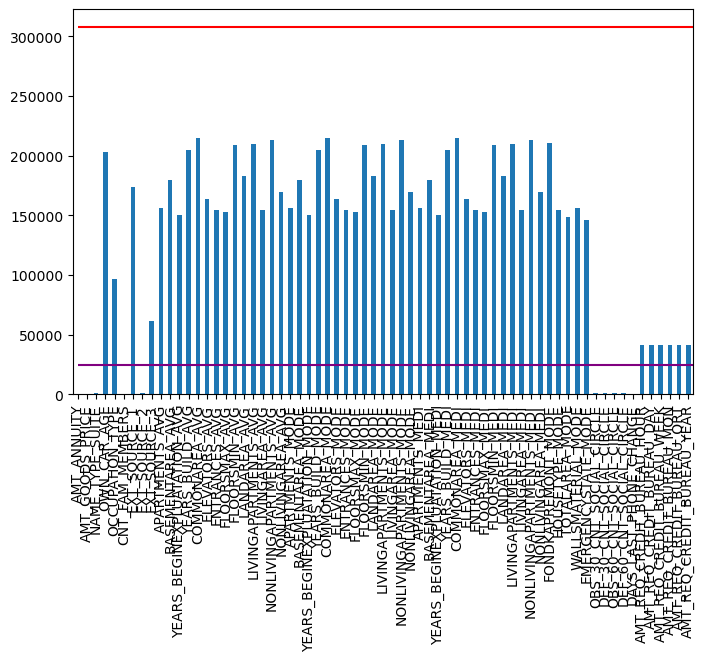

In [3]:
# 透過視覺化確認資料null的狀況
plt.figure(figsize=(8,5))
plt.tick_params(colors='black', which='both')
df_app.isna().sum()[df_app.isna().sum()>0].plot(kind='bar')
# df_app[df_app['TARGET'] == 1].isna().sum()[(df_app[df_app['TARGET'] == 1].isna().sum()>0)].plot(kind='bar', color = 'gray')
plt.hlines(y = len(df_app), xmin = 0, xmax = len(df_app.columns), color = 'red')
plt.hlines(y = len(df_app[df_app['TARGET'] == 1]), xmin = 0, xmax = len(df_app.columns), color = 'purple')
plt.tight_layout

In [4]:
defaulters = df_app[df_app.TARGET == 1]
nondefaulters = df_app[df_app.TARGET == 0]

def biplot(data, var, label_rotation):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 8))
    s1 = sns.barplot(ax=ax1, x=defaulters[var].value_counts().index, data=defaulters,
                        y=100. * defaulters[var].value_counts(normalize=True))
    if (label_rotation):
        s1.set_xticklabels(s1.get_xticklabels(), rotation=90, fontsize=12)
    ax1.set_title('Distribution of ' + '%s' % var + ' - Defaulters', fontsize=15)
    ax1.set_xlabel('%s' % var, fontsize=15)
    ax1.set_ylabel("% of Loans", fontsize=15)

    s2 = sns.barplot(ax=ax2, x=nondefaulters[var].value_counts().index, data=nondefaulters,
                        y=100. * nondefaulters[var].value_counts(normalize=True))
    if (label_rotation):
        s2.set_xticklabels(s2.get_xticklabels(), rotation=90, fontsize=12)
    ax2.set_xlabel('%s' % var, fontsize=15)
    ax2.set_ylabel("% of Loans", fontsize=15)
    ax2.set_title('Distribution of ' + '%s' % var + ' - Non-Defaulters', fontsize=15)
    plt.tight_layout()

## Create X Y data

In [5]:
Y = df_app['TARGET']
X = df_app.drop(columns = ['TARGET','SK_ID_CURR'])
X.head()

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.079,0.0554,0.0,0.0,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

## Data Preprocessing(Null values...)

In [6]:
np.where(X.isna().sum()>30751)

(array([ 19,  26,  39,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,
         51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,
         64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,
         77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88, 114,
        115, 116, 117, 118, 119]),)

In [7]:
X.columns[[19,  26,  39,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,
         51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,
         64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,
         77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88, 114,
        115, 116, 117, 118, 119]]

Index(['OWN_CAR_AGE', 'OCCUPATION_TYPE', 'EXT_SOURCE_1', 'EXT_SOURCE_3',
       'APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG',
       'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'ELEVATORS_AVG', 'ENTRANCES_AVG',
       'FLOORSMAX_AVG', 'FLOORSMIN_AVG', 'LANDAREA_AVG',
       'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG', 'NONLIVINGAPARTMENTS_AVG',
       'NONLIVINGAREA_AVG', 'APARTMENTS_MODE', 'BASEMENTAREA_MODE',
       'YEARS_BEGINEXPLUATATION_MODE', 'YEARS_BUILD_MODE', 'COMMONAREA_MODE',
       'ELEVATORS_MODE', 'ENTRANCES_MODE', 'FLOORSMAX_MODE', 'FLOORSMIN_MODE',
       'LANDAREA_MODE', 'LIVINGAPARTMENTS_MODE', 'LIVINGAREA_MODE',
       'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAREA_MODE', 'APARTMENTS_MEDI',
       'BASEMENTAREA_MEDI', 'YEARS_BEGINEXPLUATATION_MEDI', 'YEARS_BUILD_MEDI',
       'COMMONAREA_MEDI', 'ELEVATORS_MEDI', 'ENTRANCES_MEDI', 'FLOORSMAX_MEDI',
       'FLOORSMIN_MEDI', 'LANDAREA_MEDI', 'LIVINGAPARTMENTS_MEDI',
       'LIVINGAREA_MEDI', 'NONLIVINGAPARTMEN

In [8]:
X.drop(['OWN_CAR_AGE', 'OCCUPATION_TYPE', 'EXT_SOURCE_1', 'EXT_SOURCE_3',
       'APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG',
       'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'ELEVATORS_AVG', 'ENTRANCES_AVG',
       'FLOORSMAX_AVG', 'FLOORSMIN_AVG', 'LANDAREA_AVG',
       'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG', 'NONLIVINGAPARTMENTS_AVG',
       'NONLIVINGAREA_AVG', 'APARTMENTS_MODE', 'BASEMENTAREA_MODE',
       'YEARS_BEGINEXPLUATATION_MODE', 'YEARS_BUILD_MODE', 'COMMONAREA_MODE',
       'ELEVATORS_MODE', 'ENTRANCES_MODE', 'FLOORSMAX_MODE', 'FLOORSMIN_MODE',
       'LANDAREA_MODE', 'LIVINGAPARTMENTS_MODE', 'LIVINGAREA_MODE',
       'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAREA_MODE', 'APARTMENTS_MEDI',
       'BASEMENTAREA_MEDI', 'YEARS_BEGINEXPLUATATION_MEDI', 'YEARS_BUILD_MEDI',
       'COMMONAREA_MEDI', 'ELEVATORS_MEDI', 'ENTRANCES_MEDI', 'FLOORSMAX_MEDI',
       'FLOORSMIN_MEDI', 'LANDAREA_MEDI', 'LIVINGAPARTMENTS_MEDI',
       'LIVINGAREA_MEDI', 'NONLIVINGAPARTMENTS_MEDI', 'NONLIVINGAREA_MEDI',
       'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'TOTALAREA_MODE',
       'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE',
       'AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY',
       'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_MON',
       'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR'], axis=1, inplace=True)
X

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_2,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21
0,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,1,1,0,1,1,0,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.262949,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,1,1,0,1,1,0,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.622246,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,1,1,1,1,1,0,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,0.555912,0.0,0.0,0.0,0.0,-815.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,0.008019,-19005,-3039,-9833.0,-2437,1,1,0,1,0,0,2.0,2,2,WEDNESDAY,17,0,0,0,0,0,0,Business Entity Type 3,0.650442,2.0,0.0,2.0,0.0,-617.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.028663,-19932,-3038,-4311.0,-3458,1,1,0,1,0,0,1.0,2,2,THURSDAY,11,0,0,0,0,1,1,Religion,0.322738,0.0,0.0,0.0,0.0,-1106.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,Cash loans,M,N,N,0,157500.0,254700.0,27558.0,225000.0,Unaccompanied,Working,Secondary / secondary special,Separated,With parents,0.032561,-9327,-236,-8456.0,-1982,1,1,0,1,0,0,1.0,1,1,THURSDAY,15,0,0,0,0,0,0,Services,0.681632,0.0,0.0,0.0,0.0,-273.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
307507,Cash loans,F,N,Y,0,72000.0,269550.0,12001.5,225000.0,Unaccompanied,Pensioner,Secondary / secondary special,Widow,House / apartment,0.025164,-20775,365243,-4388.0,-4090,1,0,0,1,1,0,1.0,2,2,MONDAY,8,0,0,0,0,0,0,XNA,0.115992,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
307508,Cash loans,F,N,Y,0,153000.0,677664.0,29979.0,585000.0,Unaccompanied,Working,Higher education,Separated,House / apartment,0.005002,-14966,-7921,-6737.0,-5150,1,1,0,1,0,1,1.0,3,3,THURSDAY,9,0,0,0,0,1,1,School,0.535722,6.0,0.0,6.0,0.0,-1909.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
307509,Cash loans,F,N,Y,0,171000.0,370107.0,20205.0,319500.0,Unaccompanied,Commercial associate,Secondary / secondary special,Married,House / apartment,0.005313,-11961,-4786,-2562.0,-931,1,1,0,1,0,

In [9]:
obj_list = X.select_dtypes('object').columns
X[obj_list].isnull().sum()

NAME_CONTRACT_TYPE               0
CODE_GENDER                      0
FLAG_OWN_CAR                     0
FLAG_OWN_REALTY                  0
NAME_TYPE_SUITE               1292
NAME_INCOME_TYPE                 0
NAME_EDUCATION_TYPE              0
NAME_FAMILY_STATUS               0
NAME_HOUSING_TYPE                0
WEEKDAY_APPR_PROCESS_START       0
ORGANIZATION_TYPE                0
dtype: int64

In [10]:
def mode_impute(df,col):
    return df[col].fillna(df[col].mode()[0])

In [11]:
X['NAME_TYPE_SUITE']=mode_impute(X, 'NAME_TYPE_SUITE')

In [12]:
X.select_dtypes('float').isna().sum()

AMT_INCOME_TOTAL                 0
AMT_CREDIT                       0
AMT_ANNUITY                     12
AMT_GOODS_PRICE                278
REGION_POPULATION_RELATIVE       0
DAYS_REGISTRATION                0
CNT_FAM_MEMBERS                  2
EXT_SOURCE_2                   660
OBS_30_CNT_SOCIAL_CIRCLE      1021
DEF_30_CNT_SOCIAL_CIRCLE      1021
OBS_60_CNT_SOCIAL_CIRCLE      1021
DEF_60_CNT_SOCIAL_CIRCLE      1021
DAYS_LAST_PHONE_CHANGE           1
dtype: int64

In [13]:
float_col = X.select_dtypes('float').columns
for k in float_col:
    X[k] = X[k].interpolate(method ='linear', limit_direction ='forward')

In [14]:
X['CODE_GENDER'].replace('XNA', 'M', inplace=True)

X['ORGANIZATION_TYPE'].replace('XNA', 'Business Entity Type 3', inplace=True)
X['ORGANIZATION_TYPE'].replace(['Business Entity Type 1', 'Business Entity Type 2', 'Business Entity Type 3'], 'Business Entity Type', inplace=True)
X['ORGANIZATION_TYPE'].replace(['Trade: type 1', 'Trade: type 2', 'Trade: type 3','Trade: type 4', 'Trade: type 5', 'Trade: type 6', 'Trade: type 7'], 'Trade Type', inplace=True)
X['ORGANIZATION_TYPE'].replace(['Industry: type 1', 'Industry: type 2', 'Industry: type 3','Industry: type 4', 'Industry: type 5', 'Industry: type 6', 'Industry: type 7', 
                                'Industry: type 8', 'Industry: type 9', 'Industry: type 10', 'Industry: type 11', 'Industry: type 12', 'Industry: type 13'], 'Industry Type', inplace=True)
X['ORGANIZATION_TYPE'].replace(['Transport: type 1', 'Transport: type 2', 'Transport: type 3','Transport: type 4'], 'Transport Type', inplace=True)
X['ORGANIZATION_TYPE'].replace(['Hotel', 'Electricity', 'Insurance', 'Telecom', 'Emergency', 'Advertising', 'Realtor', 'Culture', 'Mobile', 'Legal Services', 'Cleaning', 'Religion', 'Security', 'Housing',
                                'Military', 'Bank', 'Agriculture', 'Police', 'Postal', 'Security Ministries', 'Restaurant', 'Services', 'University'], 'Other', inplace=True)

X['NAME_HOUSING_TYPE'].replace(['Co-op apartment', 'Office apartment', 'Rented apartment'], 'Other', inplace=True)

X['NAME_TYPE_SUITE'].replace(['Group of people', 'Other_A', 'Other_B', 'Children'], 'Working', inplace=True)
X['NAME_TYPE_SUITE'].replace('Spouse, partner', 'Spouse partner', inplace=True)

X['NAME_INCOME_TYPE'].replace(['Unemployed', 'Student', 'Businessman', 'Maternity leave'], 'Other', inplace=True)

X['NAME_FAMILY_STATUS'].replace(['Unknown'], 'Married', inplace=True)

## 刪除過多一樣的

In [15]:
X.drop(['OBS_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE','DEF_30_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE', 'FLAG_MOBIL', 'FLAG_CONT_MOBILE', 'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_12', 'FLAG_EMAIL',
        'FLAG_DOCUMENT_4','FLAG_DOCUMENT_5','FLAG_DOCUMENT_7','FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15','FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_18',
        'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21', 'FLAG_WORK_PHONE', 'REG_REGION_NOT_LIVE_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_REGION_NOT_WORK_REGION', 'WEEKDAY_APPR_PROCESS_START',
        'HOUR_APPR_PROCESS_START', 'REGION_RATING_CLIENT','REGION_RATING_CLIENT_W_CITY'], axis = 1, inplace=True)

Text(0.5, 1.0, 'FLAG_DOCUMENT_21')

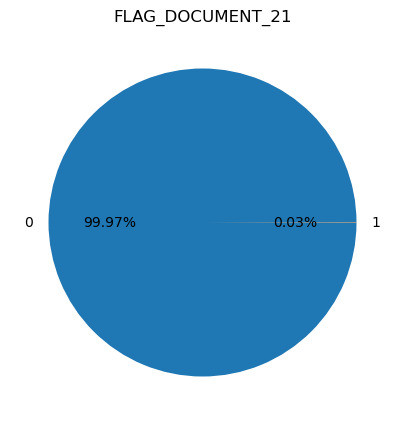

In [16]:
plt.figure(figsize=(10,5))
df_app['FLAG_DOCUMENT_21'].value_counts().plot(kind='pie', autopct='%1.2f%%')
plt.ylabel('')
plt.title('FLAG_DOCUMENT_21')

In [17]:
X

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_EMP_PHONE,FLAG_PHONE,CNT_FAM_MEMBERS,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_2,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_3,FLAG_DOCUMENT_6,FLAG_DOCUMENT_8
0,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,1,1,1.0,0,0,0,Business Entity Type,0.262949,-1134.0,1,0,0
1,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,1,1,2.0,0,0,0,School,0.622246,-828.0,1,0,0
2,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,1,1,1.0,0,0,0,Government,0.555912,-815.0,0,0,0
3,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,0.008019,-19005,-3039,-9833.0,-2437,1,0,2.0,0,0,0,Business Entity Type,0.650442,-617.0,1,0,0
4,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.028663,-19932,-3038,-4311.0,-3458,1,0,1.0,0,1,1,Other,0.322738,-1106.0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,Cash loans,M,N,N,0,157500.0,254700.0,27558.0,225000.0,Unaccompanied,Working,Secondary / secondary special,Separated,With parents,0.032561,-9327,-236,-8456.0,-1982,1,0,1.0,0,0,0,Other,0.681632,-273.0,0,0,1
307507,Cash loans,F,N,Y,0,72000.0,269550.0,12001.5,225000.0,Unaccompanied,Pensioner,Secondary / secondary special,Widow,House / apartment,0.025164,-20775,365243,-4388.0,-4090,0,1,1.0,0,0,0,Business Entity Type,0.115992,0.0,1,0,0
307508,Cash loans,F,N,Y,0,153000.0,677664.0,29979.0,585000.0,Unaccompanied,Working,Higher education,Separated,House / apartment,0.005002,-14966,-7921,-6737.0,-5150,1,0,1.0,0,1,1,School,0.535722,-1909.0,1,0,0
307509,Cash loans,F,N,Y,0,171000.0,370107.0,20205.0,319500.0,Unaccompanied,Commercial associate,Secondary / secondary special,Married,House / apartment,0.005313,-11961,-4786,-2562.0,-931,1,0,2.0,1,1,0,Business Entity Type,0.514163,-322.0,1,0,0


In [18]:
X_discrete = X[['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY','NAME_TYPE_SUITE', 'NAME_INCOME_TYPE',
       'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'FLAG_EMP_PHONE', 'FLAG_PHONE', 'REG_CITY_NOT_LIVE_CITY','REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY',
       'ORGANIZATION_TYPE', 'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_8']]
X_continuous = X.drop(['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY','NAME_TYPE_SUITE', 'NAME_INCOME_TYPE',
       'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'FLAG_EMP_PHONE', 'FLAG_PHONE', 'REG_CITY_NOT_LIVE_CITY','REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY',
       'ORGANIZATION_TYPE', 'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_8'], axis=1)

In [19]:
X_prep = pd.concat([X_continuous, X_discrete], axis = 1)
X_prep

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,CNT_FAM_MEMBERS,EXT_SOURCE_2,DAYS_LAST_PHONE_CHANGE,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,FLAG_EMP_PHONE,FLAG_PHONE,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,FLAG_DOCUMENT_3,FLAG_DOCUMENT_6,FLAG_DOCUMENT_8
0,0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461,-637,-3648.0,-2120,1.0,0.262949,-1134.0,Cash loans,M,N,Y,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,1,1,0,0,0,Business Entity Type,1,0,0
1,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,-16765,-1188,-1186.0,-291,2.0,0.622246,-828.0,Cash loans,F,N,N,Family,State servant,Higher education,Married,House / apartment,1,1,0,0,0,School,1,0,0
2,0,67500.0,135000.0,6750.0,135000.0,0.010032,-19046,-225,-4260.0,-2531,1.0,0.555912,-815.0,Revolving loans,M,Y,Y,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,1,1,0,0,0,Government,0,0,0
3,0,135000.0,312682.5,29686.5,297000.0,0.008019,-19005,-3039,-9833.0,-2437,2.0,0.650442,-617.0,Cash loans,F,N,Y,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,1,0,0,0,0,Business Entity Type,1,0,0
4,0,121500.0,513000.0,21865.5,513000.0,0.028663,-19932,-3038,-4311.0,-3458,1.0,0.322738,-1106.0,Cash loans,M,N,Y,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,1,0,0,1,1,Other,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,0,157500.0,254700.0,27558.0,225000.0,0.032561,-9327,-236,-8456.0,-1982,1.0,0.681632,-273.0,Cash loans,M,N,N,Unaccompanied,Working,Secondary / secondary special,Separated,With parents,1,0,0,0,0,Other,0,0,1
307507,0,72000.0,269550.0,12001.5,225000.0,0.025164,-20775,365243,-4388.0,-4090,1.0,0.115992,0.0,Cash loans,F,N,Y,Unaccompanied,Pensioner,Secondary / secondary special,Widow,House / apartment,0,1,0,0,0,Business Entity Type,1,0,0
307508,0,153000.0,677664.0,29979.0,585000.0,0.005002,-14966,-7921,-6737.0,-5150,1.0,0.535722,-1909.0,Cash loans,F,N,Y,Unaccompanied,Working,Higher education,Separated,House / apartment,1,0,0,1,1,School,1,0,0
307509,0,171000.0,370107.0,20205.0,319500.0,0.005313,-11961,-4786,-2562.0,-931,2.0,0.514163,-322.0,Cash loans,F,N,Y,Unaccompanied,Commercial associate,Secondary / secondary special,Married,House / apartment,1,0,1,1,0,Business Entity Type,1,0,0


In [20]:
X_conti_col = X_continuous.columns
X_categ_col = X_discrete.columns

In [21]:
print(X.shape)
print(X.isna().sum().value_counts())

(307511, 31)
0    31
dtype: int64


## One-Hot encoding

In [22]:
X_onehot = pd.get_dummies(X, columns=list(X_categ_col), drop_first=True)
X_onehot

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,CNT_FAM_MEMBERS,EXT_SOURCE_2,DAYS_LAST_PHONE_CHANGE,NAME_CONTRACT_TYPE_Revolving loans,CODE_GENDER_M,FLAG_OWN_CAR_Y,FLAG_OWN_REALTY_Y,NAME_TYPE_SUITE_Spouse partner,NAME_TYPE_SUITE_Unaccompanied,NAME_TYPE_SUITE_Working,NAME_INCOME_TYPE_Other,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Other,NAME_HOUSING_TYPE_With parents,FLAG_EMP_PHONE_1,FLAG_PHONE_1,REG_CITY_NOT_LIVE_CITY_1,REG_CITY_NOT_WORK_CITY_1,LIVE_CITY_NOT_WORK_CITY_1,ORGANIZATION_TYPE_Construction,ORGANIZATION_TYPE_Government,ORGANIZATION_TYPE_Industry Type,ORGANIZATION_TYPE_Kindergarten,ORGANIZATION_TYPE_Medicine,ORGANIZATION_TYPE_Other,ORGANIZATION_TYPE_School,ORGANIZATION_TYPE_Self-employed,ORGANIZATION_TYPE_Trade Type,ORGANIZATION_TYPE_Transport Type,FLAG_DOCUMENT_3_1,FLAG_DOCUMENT_6_1,FLAG_DOCUMENT_8_1
0,0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461,-637,-3648.0,-2120,1.0,0.262949,-1134.0,0,1,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,-16765,-1188,-1186.0,-291,2.0,0.622246,-828.0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0
2,0,67500.0,135000.0,6750.0,135000.0,0.010032,-19046,-225,-4260.0,-2531,1.0,0.555912,-815.0,1,1,1,1,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,0,135000.0,312682.5,29686.5,297000.0,0.008019,-19005,-3039,-9833.0,-2437,2.0,0.650442,-617.0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,0,121500.0,513000.0,21865.5,513000.0,0.028663,-19932,-3038,-4311.0,-3458,1.0,0.322738,-1106.0,0,1,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,0,157500.0,254700.0,27558.0,225000.0,0.032561,-9327,-236,-8456.0,-1982,1.0,0.681632,-273.0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
307507,0,72000.0,269550.0,12001.5,225000.0,0.025164,-20775,365243,-4388.0,-4090,1.0,0.115992,0.0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
307508,0,153000.0,677664.0,29979.0,585000.0,0.005002,-14966,-7921,-6737.0,-5150,1.0,0.535722,-1909.0,0,0,0,1,0,1,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,1,0,0,0,1,0,0
307509,0,171000.0,370107.0,20205.0,319500.0,0.005313,-11961,-4786,-2562.0,-931,2.0,0.514163,-322.0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [23]:
X_onehot_continuous = X_onehot[['CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY',
       'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH',
       'CNT_FAM_MEMBERS', 'EXT_SOURCE_2', 'DAYS_LAST_PHONE_CHANGE']]
X_onehot_discrete = X_onehot.drop(['CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY',
       'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH',
       'CNT_FAM_MEMBERS', 'EXT_SOURCE_2', 'DAYS_LAST_PHONE_CHANGE'],axis = 1)
conti_col = X_onehot_continuous.columns
categ_col = X_onehot_discrete.columns

In [24]:
print(conti_col.shape)
print(categ_col.shape)

(13,)
(40,)


## 資料標準化

### 資料切分與標準化

In [25]:
x_train, x_test, y_train, y_test = train_test_split(X_onehot, Ｙ, test_size= 0.3, random_state = 1)

### 訓練集標準化&平衡

In [26]:
scalor = StandardScaler().fit(x_train[conti_col])
x_scaled = scalor.transform(x_train[conti_col])
X_train = pd.DataFrame(columns = conti_col.append(categ_col))
Y_train = y_train
X_train[categ_col] = x_train[categ_col].values
X_train[conti_col] = x_scaled

### 測試集標準化

In [27]:
scalor = StandardScaler().fit(x_test[conti_col])
x_test_scaled = scalor.transform(x_test[conti_col])
X_test = pd.DataFrame(columns = conti_col.append(categ_col))
Y_test = y_test
X_test[categ_col] = x_test[categ_col].values
X_test[conti_col] = x_test_scaled

### 共線性檢驗

In [28]:
def checkVIF(df, draw = False):
    df['c'] = 1
    name = df.columns
    x = np.matrix(df)
    VIF_list = [variance_inflation_factor(x,i) for i in range(x.shape[1])]
    VIF = pd.DataFrame({'feature':name, 'VIF':VIF_list})
    #remove VIF>10
    dropcol = list(VIF[VIF['VIF']>10]['feature'])
    # dropcol.append('c')
    for i in dropcol:
        del df[i]
    if draw == True:
        # draw heamap
        plt.figure(figsize =(20,20))
        corr = df.corr
        # creating mask
        mask = np.triu(np.ones_like(corr))
        # plotting a triangle correlation heatmap
        dataplot = sns.heatmap(corr, cmap = 'YlGnBu', annot = True, fmt ='.2f', mask=mask)
        plt.show()
    return df

In [29]:
X_train = checkVIF(X_train, False)
X_train

,AMT_INCOME_TOTAL,AMT_ANNUITY,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_REGISTRATION,DAYS_ID_PUBLISH,EXT_SOURCE_2,DAYS_LAST_PHONE_CHANGE,NAME_CONTRACT_TYPE_Revolving loans,CODE_GENDER_M,FLAG_OWN_CAR_Y,FLAG_OWN_REALTY_Y,NAME_TYPE_SUITE_Spouse partner,NAME_TYPE_SUITE_Unaccompanied,NAME_TYPE_SUITE_Working,NAME_INCOME_TYPE_Other,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Working,NAME_FAMILY_STATUS_Married,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Other,NAME_HOUSING_TYPE_With parents,FLAG_PHONE_1,REG_CITY_NOT_LIVE_CITY_1,REG_CITY_NOT_WORK_CITY_1,LIVE_CITY_NOT_WORK_CITY_1,ORGANIZATION_TYPE_Construction,ORGANIZATION_TYPE_Government,ORGANIZATION_TYPE_Industry Type,ORGANIZATION_TYPE_Kindergarten,ORGANIZATION_TYPE_Medicine,ORGANIZATION_TYPE_Other,ORGANIZATION_TYPE_School,ORGANIZATION_TYPE_Self-employed,ORGANIZATION_TYPE_Trade Type,ORGANIZATION_TYPE_Transport Type,FLAG_DOCUMENT_3_1,FLAG_DOCUMENT_6_1,FLAG_DOCUMENT_8_1
0,0.305271,0.148944,-0.993651,0.252556,1.413904,-1.068489,0.517169,0.199371,1,0,0,1,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,-0.500995,0.239592,-0.307355,-1.368899,0.569124,-1.353332,0.993709,-0.701921,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,-0.218802,-0.316711,-0.662288,1.385102,1.313200,0.899576,0.613671,0.753454,1,1,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2.522503,1.696784,0.715221,0.417585,1.116047,-1.314249,1.370494,-1.794359,0,0,0,1,0,1,0,0,1,0,1,0,0,0,1,0,1,1,0,0,0,0,0,1,0,0,0,0,1,0,0
4,0.305271,-0.540537,3.734071,-0.338209,-0.146018,1.274508,1.200272,-0.511984,0,1,1,1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
215252,1.111537,1.804817,0.310977,0.592915,-0.067440,0.816110,0.316010,-1.004368,0,0,0,1,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0
215253,-0.097862,0.384566,-0.783106,-1.018927,-0.780028,-0.683620,0.578385,-0.522872,0,0,0,1,0,1,0,0,0,1,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0
215254,-0.299429,-0.937586,1.833381,0.702782,1.202567,0.902888,0.955020,0.294944,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
215255,-0.299429,1.431050,-0.884836,-0.050952,0.082623,-0.886322,0.217820,-0.203488,0,1,0,1,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0


In [30]:
X_test = X_test[X_train.columns]
X_test

,AMT_INCOME_TOTAL,AMT_ANNUITY,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_REGISTRATION,DAYS_ID_PUBLISH,EXT_SOURCE_2,DAYS_LAST_PHONE_CHANGE,NAME_CONTRACT_TYPE_Revolving loans,CODE_GENDER_M,FLAG_OWN_CAR_Y,FLAG_OWN_REALTY_Y,NAME_TYPE_SUITE_Spouse partner,NAME_TYPE_SUITE_Unaccompanied,NAME_TYPE_SUITE_Working,NAME_INCOME_TYPE_Other,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Working,NAME_FAMILY_STATUS_Married,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Other,NAME_HOUSING_TYPE_With parents,FLAG_PHONE_1,REG_CITY_NOT_LIVE_CITY_1,REG_CITY_NOT_WORK_CITY_1,LIVE_CITY_NOT_WORK_CITY_1,ORGANIZATION_TYPE_Construction,ORGANIZATION_TYPE_Government,ORGANIZATION_TYPE_Industry Type,ORGANIZATION_TYPE_Kindergarten,ORGANIZATION_TYPE_Medicine,ORGANIZATION_TYPE_Other,ORGANIZATION_TYPE_School,ORGANIZATION_TYPE_Self-employed,ORGANIZATION_TYPE_Trade Type,ORGANIZATION_TYPE_Transport Type,FLAG_DOCUMENT_3_1,FLAG_DOCUMENT_6_1,FLAG_DOCUMENT_8_1
0,-0.087127,0.308306,-1.125411,-1.053419,-1.136278,-0.066929,0.563861,-0.328368,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,-0.087127,-0.121244,-0.740084,1.596592,0.875368,0.830970,0.738614,0.708736,0,1,1,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0
2,-0.143670,-0.717583,0.844455,0.022071,-0.806784,-0.945611,0.816438,0.752251,0,1,1,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
3,0.195586,0.631012,-0.663453,1.402218,-0.441754,0.346568,-0.152463,-0.367047,0,1,1,0,0,1,0,0,0,1,1,0,0,0,1,0,1,1,0,0,0,0,0,1,0,0,0,0,1,0,0
4,0.082501,0.552742,-0.786136,0.981534,0.172884,1.932305,-1.404063,0.533468,0,1,0,1,0,1,0,0,0,1,1,1,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92249,-0.222830,-0.064406,-0.819174,-0.682362,0.977145,0.783922,-0.257358,-0.034642,0,1,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
92250,-0.177596,-1.126945,-0.813318,0.053548,0.317588,-0.796514,-0.191794,-1.492389,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0
92251,-0.030585,0.809603,0.562653,0.006908,0.082764,-1.131818,-0.413421,0.486327,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,1,0,0
92252,-0.143670,1.079508,0.713892,-0.935553,-1.172099,0.329339,-0.098472,0.193810,0,0,1,1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


### 資料平衡

In [31]:
X_train, Y_train = SMOTE(random_state=1).fit_resample(X_train, Y_train)

## Logistic Regression

In [32]:
import copy
def Logit_model(x_train,y_train, verbose = True):
    included = list(X_train.columns)
    bic=[]
    while True:
        changed=False
        model_stepwise=sm.Logit(y_train ,sm.add_constant(pd.DataFrame(x_train[included]))).fit()
        bic=model_stepwise.bic
        bic_new={}
        for i in included:
            new_included = copy.deepcopy(included)
            new_included.remove(i)
            model_stepwise_new = sm.Logit(y_train, sm.add_constant(pd.DataFrame(x_train[new_included]))).fit()
            bic_new[i]=model_stepwise_new.bic
        if len(included) <= 10:
            break
        if min(bic_new.values()) < bic:
            changed = True
            included.remove(min(bic_new,key = bic_new.get))
            if verbose:
                print('Drop {} with BIC decrease by {}'.format(min(bic_new, key = bic_new.get), (bic-min(bic_new.values()))))
        if not changed:
            break
    return included


In [33]:
included = Logit_model(X_train, Y_train, True)

Optimization terminated successfully.
         Current function value: 0.548413
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.548569
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.548414
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.548690
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.555483
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.549049
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.549412
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.566616
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.548822
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.558561
  

In [34]:
included

['AMT_INCOME_TOTAL',
 'REGION_POPULATION_RELATIVE',
 'DAYS_BIRTH',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'EXT_SOURCE_2',
 'DAYS_LAST_PHONE_CHANGE',
 'NAME_CONTRACT_TYPE_Revolving loans',
 'CODE_GENDER_M',
 'FLAG_OWN_CAR_Y',
 'FLAG_OWN_REALTY_Y',
 'NAME_TYPE_SUITE_Spouse partner',
 'NAME_TYPE_SUITE_Unaccompanied',
 'NAME_TYPE_SUITE_Working',
 'NAME_INCOME_TYPE_State servant',
 'NAME_INCOME_TYPE_Working',
 'NAME_FAMILY_STATUS_Married',
 'NAME_HOUSING_TYPE_Municipal apartment',
 'NAME_HOUSING_TYPE_Other',
 'NAME_HOUSING_TYPE_With parents',
 'FLAG_PHONE_1',
 'REG_CITY_NOT_LIVE_CITY_1',
 'REG_CITY_NOT_WORK_CITY_1',
 'LIVE_CITY_NOT_WORK_CITY_1',
 'ORGANIZATION_TYPE_Construction',
 'ORGANIZATION_TYPE_Government',
 'ORGANIZATION_TYPE_Industry Type',
 'ORGANIZATION_TYPE_Kindergarten',
 'ORGANIZATION_TYPE_Medicine',
 'ORGANIZATION_TYPE_Other',
 'ORGANIZATION_TYPE_School',
 'ORGANIZATION_TYPE_Self-employed',
 'ORGANIZATION_TYPE_Trade Type',
 'ORGANIZATION_TYPE_Transport Type',
 'FLAG_DOCUMEN

In [51]:
x_log = sm.add_constant(X_train[included], prepend=False)
logit = sm.Logit(Y_train, x_log)
logit_fit = logit.fit()
print(logit_fit.summary())

Optimization terminated successfully.
         Current function value: 0.548429
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                 TARGET   No. Observations:               395798
Model:                          Logit   Df Residuals:                   395760
Method:                           MLE   Df Model:                           37
Date:                Thu, 24 Nov 2022   Pseudo R-squ.:                  0.2088
Time:                        13:36:12   Log-Likelihood:            -2.1707e+05
converged:                       True   LL-Null:                   -2.7435e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
AMT_INCOME_TOTAL                         -0.0621      

In [36]:
included_v2 = ['NAME_CONTRACT_TYPE_Revolving loans', 'NAME_TYPE_SUITE_Spouse partner', 'NAME_TYPE_SUITE_Working', 'NAME_HOUSING_TYPE_Municipal apartment', 'NAME_HOUSING_TYPE_Other', 'NAME_HOUSING_TYPE_With parents', 'ORGANIZATION_TYPE_Construction', 'ORGANIZATION_TYPE_Government', 'ORGANIZATION_TYPE_Industry Type','ORGANIZATION_TYPE_Kindergarten', 'ORGANIZATION_TYPE_Medicine', 'ORGANIZATION_TYPE_Other', 'ORGANIZATION_TYPE_School', 
                'ORGANIZATION_TYPE_Trade Type','ORGANIZATION_TYPE_Transport Type', 'FLAG_DOCUMENT_3_1', 'FLAG_DOCUMENT_6_1', 'FLAG_DOCUMENT_8_1', 'REG_CITY_NOT_LIVE_CITY_1', 'ORGANIZATION_TYPE_Self-employed']

In [37]:
x_log = sm.add_constant(X_train[included_v2], prepend=False)
logit = sm.Logit(Y_train, x_log)
logit_fit = logit.fit()
print(logit_fit.summary())

Optimization terminated successfully.
         Current function value: 0.622635
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                 TARGET   No. Observations:               395798
Model:                          Logit   Df Residuals:                   395777
Method:                           MLE   Df Model:                           20
Date:                Thu, 24 Nov 2022   Pseudo R-squ.:                  0.1017
Time:                        13:21:34   Log-Likelihood:            -2.4644e+05
converged:                       True   LL-Null:                   -2.7435e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
NAME_CONTRACT_TYPE_Revolving loans       -1.7072      

In [52]:
print("Logit train accuracy")
print('Accuracy = ',metrics.accuracy_score(Y_train, list(map(round,logit_fit.predict(sm.add_constant(X_train[included]))))))
print('Precision = ', metrics.precision_score(Y_train, list(map(round,logit_fit.predict(sm.add_constant(X_train[included]))))))
print('Recall = ',metrics.recall_score(Y_train, list(map(round,logit_fit.predict(sm.add_constant(X_train[included]))))))
print('F1-score = ', metrics.f1_score(Y_train, list(map(round,logit_fit.predict(sm.add_constant(X_train[included]))))))
print('MSE = ', mean_squared_error(Y_train,list(map(round,logit_fit.predict(sm.add_constant(X_train[included]))))))
print(metrics.confusion_matrix(Y_train,list(map(round,logit_fit.predict(sm.add_constant(X_train[included]))))))
print('================================================================================================================')
print("Logit test accuracy")
print('Accuracy = ',metrics.accuracy_score(Y_test, list(map(round,logit_fit.predict(sm.add_constant(X_test[included]))))))
print('Precision = ', metrics.precision_score(Y_test, list(map(round,logit_fit.predict(sm.add_constant(X_test[included]))))))
print('Recall = ',metrics.recall_score(Y_test, list(map(round,logit_fit.predict(sm.add_constant(X_test[included]))))))
print('F1-score = ', metrics.f1_score(Y_test, list(map(round,logit_fit.predict(sm.add_constant(X_test[included]))))))
print('MSE = ', mean_squared_error(Y_test,list(map(round,logit_fit.predict(sm.add_constant(X_test[included]))))))
print(metrics.confusion_matrix(Y_test, list(map(round,logit_fit.predict(sm.add_constant(X_test[included]))))))

Logit train accuracy
Accuracy =  0.4975947326666633
Precision =  0.43327726380712084
Recall =  0.015619078418789383
F1-score =  0.030151243946096484
MSE =  0.5024052673333367
[[193856   4043]
 [194808   3091]]
Logit test accuracy
Accuracy =  0.90083898801136
Precision =  0.042958129418162044
Recall =  0.010579884826570242
F1-score =  0.016978293574038256
MSE =  0.09916101198864005
[[83027  1760]
 [ 7388    79]]


## Decision Tree

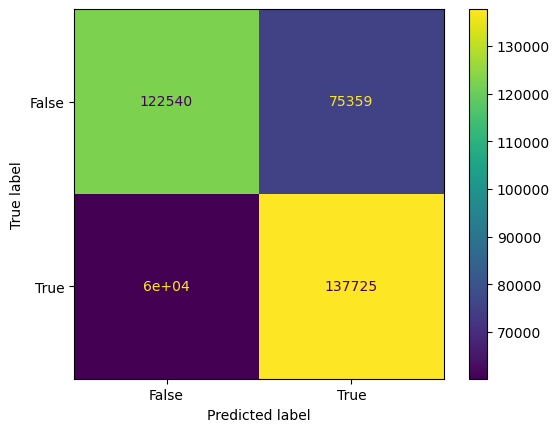

Accuracy =  0.6575702757467193
Precision =  0.6463413489515871
Recall =  0.6959358056382297
F1-score =  0.6702223692950804
RMSE =  0.5851749518334501


In [39]:
clf_labeled = DecisionTreeClassifier()
clf_labeled = clf_labeled.fit(X_train[included_v2], Y_train)

# make prediction
y_predict = clf_labeled.predict(X_train[included_v2])
# plot confusion matirx
confusion_matrix = metrics.confusion_matrix(Y_train, y_predict)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.tick_params(colors='black', which='both')
plt.show() 

# print score
print('Accuracy = ',metrics.accuracy_score(Y_train, y_predict))
print('Precision = ', metrics.precision_score(Y_train, y_predict))
print('Recall = ',metrics.recall_score(Y_train, y_predict))
print('F1-score = ', metrics.f1_score(Y_train, y_predict))
print('RMSE = ', np.sqrt(mean_squared_error(Y_train, y_predict)))

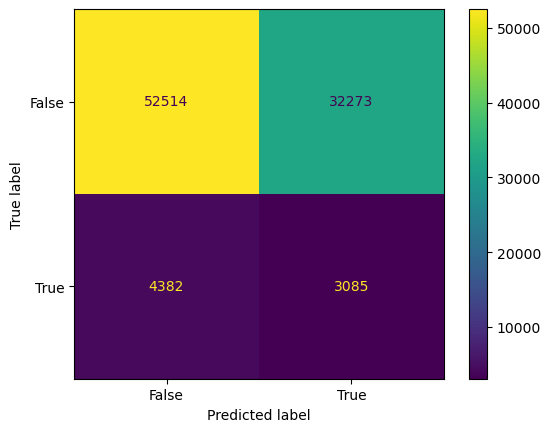

Accuracy =  0.6026730548268909
Precision =  0.0872504100910685
Recall =  0.41315119860720506
F1-score =  0.1440747227086982
RMSE =  0.6303387543005023


In [40]:
clf_labeled = DecisionTreeClassifier()
clf_labeled = clf_labeled.fit(X_train[included_v2], Y_train)
# make prediction
y_predict = clf_labeled.predict(X_test[included_v2])
# plot confusion matirx
confusion_matrix = metrics.confusion_matrix(Y_test, y_predict)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.tick_params(colors='black', which='both')
plt.show() 

# print score
print('Accuracy = ',metrics.accuracy_score(Y_test, y_predict))
print('Precision = ', metrics.precision_score(Y_test, y_predict))
print('Recall = ',metrics.recall_score(Y_test, y_predict))
print('F1-score = ', metrics.f1_score(Y_test, y_predict))
print('RMSE = ', np.sqrt(mean_squared_error(Y_test, y_predict)))

In [41]:
# parameter = {'splitter':['best', 'random'], 'criterion':['gini', 'entropy'], 'max_depth':[10, 50, 100, 300]}
# grid_result = GridSearchCV(DecisionTreeClassifier(), parameter, cv = 5, verbose=3, scoring='recall')
# grid_result.fit(X_train[included_v2], Y_train)
# best_para = grid_result.best_params_
# dc = DecisionTreeClassifier(splitter = best_para['splitter'], criterion = best_para['criterion'], max_depth=best_para['max_depth'], random_state=1)
# dc = dc.fit(X_train[included_v2], Y_train)
# y_pred_grid = dc.predict(X_train)

# confusion_matrix = metrics.confusion_matrix(Y_train, y_pred_grid)
# cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
# cm_display.plot()
# plt.tick_params(colors='black', which='both')
# plt.show()
# print('Accuracy = ',metrics.accuracy_score(Y_train, y_pred_grid))
# print('Precision = ', metrics.precision_score(Y_train, y_pred_grid))
# print('Recall = ',metrics.recall_score(Y_train, y_pred_grid))
# print('F1-score = ', metrics.f1_score(Y_train, y_pred_grid))

## RandomForest

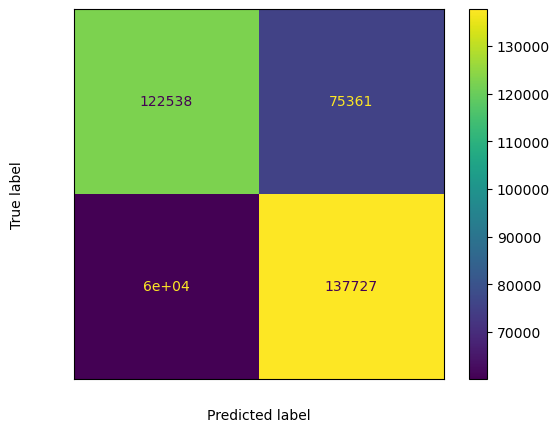

Accuracy =  0.6575702757467193
Precision =  0.646338601892176
Recall =  0.6959459118034957
F1-score =  0.6702255789112551
RMSE =  0.5851749518334501


In [42]:
clf_rndfor = RandomForestClassifier()
clf_rndfor = clf_rndfor.fit(X_train[included_v2], Y_train)

# make prediction
y_predict = clf_rndfor.predict(X_train[included_v2])

# plot confusion matirx
confusion_matrix = metrics.confusion_matrix(Y_train, y_predict)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.tick_params(colors='white', which='both')
plt.show() 

# print score
print('Accuracy = ',metrics.accuracy_score(Y_train, y_predict))
print('Precision = ', metrics.precision_score(Y_train, y_predict))
print('Recall = ',metrics.recall_score(Y_train, y_predict))
print('F1-score = ', metrics.f1_score(Y_train, y_predict))
print('RMSE = ', np.sqrt(mean_squared_error(Y_train, y_predict)))

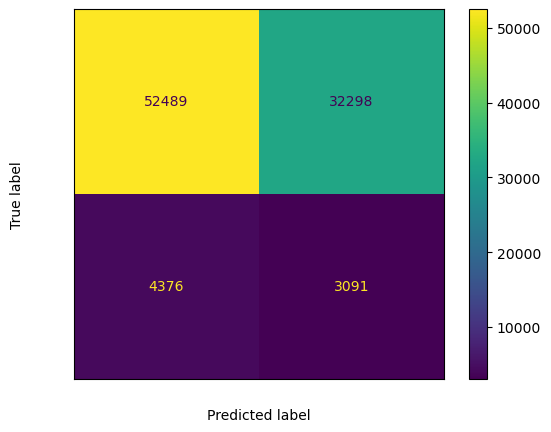

Accuracy =  0.6024671016974874
Precision =  0.08734352482409788
Recall =  0.4139547341636534
F1-score =  0.14425051334702257
RMSE =  0.6305021001570991


In [43]:
clf_rndfor = RandomForestClassifier()
clf_rndfor = clf_rndfor.fit(X_train[included_v2], Y_train)

# make prediction
y_predict = clf_rndfor.predict(X_test[included_v2])

# plot confusion matirx
confusion_matrix = metrics.confusion_matrix(Y_test, y_predict)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.tick_params(colors='white', which='both')
plt.show() 

# print score
print('Accuracy = ',metrics.accuracy_score(Y_test, y_predict))
print('Precision = ', metrics.precision_score(Y_test, y_predict))
print('Recall = ',metrics.recall_score(Y_test, y_predict))
print('F1-score = ', metrics.f1_score(Y_test, y_predict))
print('RMSE = ', np.sqrt(mean_squared_error(Y_test, y_predict)))

## LGBM

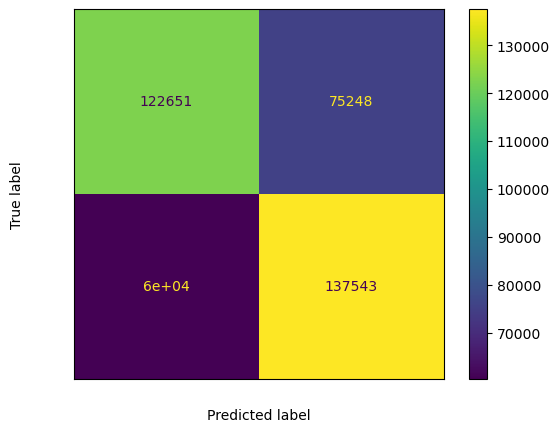

Accuracy =  0.6573908913132457
Precision =  0.6463760215422645
Recall =  0.6950161445990126
F1-score =  0.6698142151014147
RMSE =  0.5853282059552183


In [44]:
clf_lgbm = LGBMClassifier()
clf_lgbm = clf_lgbm.fit(X_train[included_v2], Y_train)

# make prediction
y_predict = clf_lgbm.predict(X_train[included_v2])

# plot confusion matirx
confusion_matrix = metrics.confusion_matrix(Y_train, y_predict)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.tick_params(colors='white', which='both')
plt.show() 

# print score
print('Accuracy = ',metrics.accuracy_score(Y_train, y_predict))
print('Precision = ', metrics.precision_score(Y_train, y_predict))
print('Recall = ',metrics.recall_score(Y_train, y_predict))
print('F1-score = ', metrics.f1_score(Y_train, y_predict))
print('RMSE = ', np.sqrt(mean_squared_error(Y_train, y_predict)))

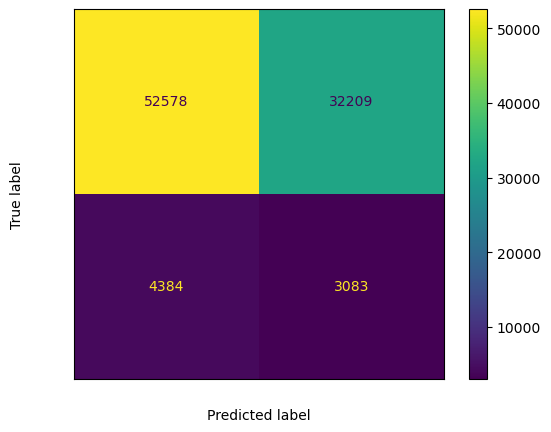

Accuracy =  0.6033451124070501
Precision =  0.08735690808115154
Recall =  0.4128833534217222
F1-score =  0.14420355948455296
RMSE =  0.6298054362999338


In [45]:
clf_lgbm = LGBMClassifier()
clf_lgbm = clf_lgbm.fit(X_train[included_v2], Y_train)

# make prediction
y_predict = clf_lgbm.predict(X_test[included_v2])

# plot confusion matirx
confusion_matrix = metrics.confusion_matrix(Y_test, y_predict)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.tick_params(colors='white', which='both')
plt.show() 

# print score
print('Accuracy = ',metrics.accuracy_score(Y_test, y_predict))
print('Precision = ', metrics.precision_score(Y_test, y_predict))
print('Recall = ',metrics.recall_score(Y_test, y_predict))
print('F1-score = ', metrics.f1_score(Y_test, y_predict))
print('RMSE = ', np.sqrt(mean_squared_error(Y_test, y_predict)))

In [46]:
# # 建立參數
# param_grid = {
# 'num_leaves': [30, 40], 
# 'feature_fraction': [0.2, 0.3],
# 'bagging_fraction': [0.6, 0.7],
# 'max_depth':[3, 5, 7],
# 'max_bin':[20],
# 'lambda_l1':[0.3, 0.6],
# 'lambda_l2':[0.08, 0.09],
# 'min_split_gain':[0.04, 0.05],
# 'min_child_weight':[7]
# }
# # 建立LightGBM模型
# lgbm = LGBMClassifier()
# # GridSearchCV
# gridsearch = GridSearchCV(lgbm, param_grid, scoring='recall')
# # 使用訓練資料訓練模型
# gridsearch.fit(X_train, Y_train)

In [47]:
# clf_LGBM = LGBMClassifier(objective = 'binary',
# learning_rate = 0.05, 
# n_estimators = 100, 
# random_state=123,
# num_leaves = gridsearch.best_params_['num_leaves'],
# feature_fraction = gridsearch.best_params_['feature_fraction'], 
# bagging_fraction = gridsearch.best_params_['bagging_fraction'],
# max_depth = gridsearch.best_params_['max_depth'],
# max_bin = gridsearch.best_params_['max_bin'],
# lambda_l1 = gridsearch.best_params_['lambda_l1'],
# lambda_l2 = gridsearch.best_params_['lambda_l2'],
# min_split_gain = gridsearch.best_params_['min_split_gain'],
# min_child_weight = gridsearch.best_params_['min_child_weight'])

# clf_LGBM = clf_LGBM.fit(X_train, Y_train)

# # make prediction
# y_predict = clf_LGBM.predict(X_train)

# # plot confusion matirx
# confusion_matrix = metrics.confusion_matrix(Y_train, y_predict)
# cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
# cm_display.plot()
# plt.tick_params(colors='black', which='both')
# plt.show() 
# # print score
# print('Accuracy = ',metrics.accuracy_score(Y_train, y_predict))
# print('Precision = ', metrics.precision_score(Y_train, y_predict))
# print('Recall = ',metrics.recall_score(Y_train, y_predict))
# print('F1-score = ', metrics.f1_score(Y_train, y_predict))

In [48]:
# # make prediction
# y_predict = clf_LGBM.predict(X_test)

# # plot confusion matirx
# confusion_matrix = metrics.confusion_matrix(Y_test, y_predict)
# cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
# cm_display.plot()
# plt.tick_params(colors='black', which='both')
# plt.show() 
# # print score
# print('Accuracy = ',metrics.accuracy_score(Y_test, y_predict))
# print('Precision = ', metrics.precision_score(Y_test, y_predict))
# print('Recall = ',metrics.recall_score(Y_test, y_predict))
# print('F1-score = ', metrics.f1_score(Y_test, y_predict))

In [49]:
# lightgbm.plot_importance(clf_lgbm, max_num_features=37)